In [1]:

### Classic VAE
###
############################################################

from __future__ import print_function
import h5py as h5
import numpy as np
import numba
import sklearn
import tensorflow as tf

print ("Numpy      ver. ", np.__version__)
print ("Numba      ver. ", numba.__version__)  ##  optimize numpy?!?
print ("H5Py       ver. ", h5.__version__)
print ("SKLearn    ver. ", sklearn.__version__)
print ("TensorFlow ver. ", tf.__version__)

import matplotlib
#matplotlib.use('agg')             ## Need for CMD
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline

tf.reset_default_graph()

from tensorflow.python.client import device_lib
print( [ x.name for x in device_lib.list_local_devices() ] )


/usr/lib64/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Numpy      ver.  1.15.4
Numba      ver.  0.41.0
H5Py       ver.  2.7.1
SKLearn    ver.  0.19.2
TensorFlow ver.  1.12.0
[u'/device:CPU:0', u'/device:XLA_GPU:0', u'/device:XLA_CPU:0', u'/device:GPU:0', u'/device:GPU:1']


Make toy data.


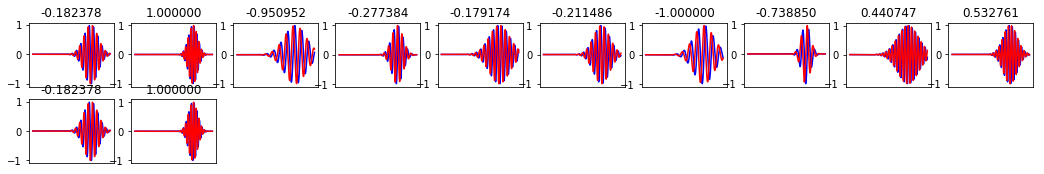

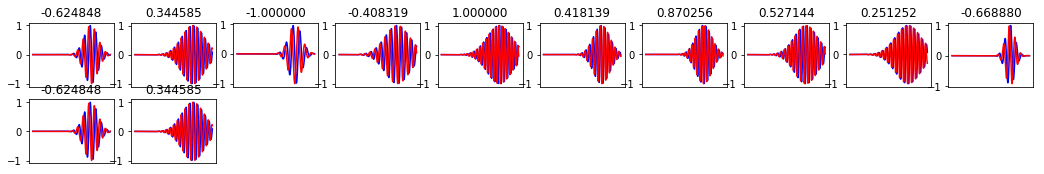

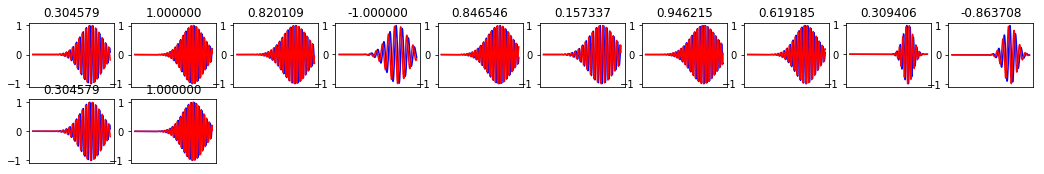

(1000, 2, 4096)
(400, 2, 4096)
(400, 2, 4096)
(1000, 2)
(400, 2)
(400, 2)
-0.994293436262229 0.9954083974134278


In [8]:
###
###  Prepare data: extract, transform, load (ETL)
###
import time
#from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

RATE = 4096
####  EDIT HERE ####
NTYPE = 10    ### Number of toy data type.
z_dim = 20     ### latent neuron
y_dim = 2     ### constraint neuron
batch_size = 32    ### We need it defined here since conv1d_transpose need a static input dimension.

h_dim = 512

TBOARD = False
####################

    
class Toydata():
    def __init__(self, ntype):
        self.ntype = ntype
        print("Make toy data.")
    
    def get_sin(self, A=1.0, N=700, PLOT=0):
        x = np.linspace(0,2*np.pi,RATE)
        y = np.random.uniform(0,np.pi,N)
        xx, yy = np.meshgrid(x, y, sparse=True)
        X1 = A*(np.sin(xx - yy))
        X2 = A*(np.cos(xx - yy))     #.astype(np.float32)
        
        #ynor = y / np.max(y)   ## normalize
        ynor = ( ( y/(2*np.pi)) - 0.5 ) *2   ## normalize
        
        Y  = np.vstack(( ynor, ynor )).astype(np.float32)
        
        if PLOT:
            plt.figure(figsize=(18,4))
            for i in range(0,len(X1)):
                idx=i
                plt.subplot(3,NTYPE,i+1)         
                plt.plot(X1[idx,:])
                plt.plot(X2[idx,:])
                plt.title("%f"%(Y[0,idx]))
                plt.xticks([])
                if (i > NTYPE): break
            plt.show()
            
        return X1,X2,np.transpose(Y)

    def get_singauss(self, f0=10, f1=30, w=1, A=1.0, N=50, PLOT=0):
        x = np.linspace(0,2*np.pi,RATE)
        #y = np.random.uniform(f0,f1, N)
        y = np.tile( np.random.uniform(f0,f1, NTYPE), N )
        xx, yy = np.meshgrid(x, y, sparse=True)
        #_ , ww = np.meshgrid(x, np.random.uniform(w*0.5,w*1.5, N ), sparse=True)
        _ , ww = np.meshgrid(x, np.tile( np.random.uniform(w*0.5,w*1.5, NTYPE ), N), sparse=True)
        X1 = A*(np.sin(yy*xx)*np.exp(-((xx-1.5*np.pi)/ww)**2))
        X2 = A*(np.cos(yy*xx)*np.exp(-((xx-1.5*np.pi)/ww)**2))     #.astype(np.float32)
        
        #ynor = y / np.max(y)   ## normalize
        ynor = ( (y-np.min(y)) / (np.max(y)-np.min(y)) - 0.5 ) *2   ## normalize
        
        Y  = np.vstack(( ynor, ynor )).astype(np.float32)
        
        if PLOT:
            plt.figure(figsize=(18,4))
            for i in range(0,len(X1)):
                plt.subplot(3,NTYPE,i+1)         
                plt.plot(X1[i,:], 'b')
                plt.plot(X2[i,:], 'r')
                plt.title("%f"%(Y[0,i]))
                plt.xticks([])
                if (i > NTYPE): break
            plt.show()
            
        return X1,X2,np.transpose(Y)
    
    
data = Toydata(ntype=NTYPE)
Xt1,Xt2,Yt = data.get_singauss(N=100, PLOT=1)
Xv1,Xv2,Yv = data.get_singauss(N=40, PLOT=1)  
Xs1,Xs2,Ys = data.get_singauss(N=40, PLOT=1)  

Xt = np.reshape( np.hstack((Xt1,Xt2)), (-1, 2, RATE) )
Xv = np.reshape( np.hstack((Xv1,Xv2)), (-1, 2, RATE) )
Xs = np.reshape( np.hstack((Xs1,Xs2)), (-1, 2, RATE) )

print (Xt.shape)
print (Xv.shape)
print (Xs.shape)
print (Yt.shape)
print (Yv.shape)
print (Ys.shape)

print( np.min(Xv[10:11,:]), np.max(Xv[10:11,:]) )

In [28]:
########
########  Original VAE
########
tf.reset_default_graph()

def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

def getDenseLayer(input_layer,weight,bias,activation=None):
    x = tf.add(tf.matmul(input_layer,weight),bias)
    if activation: x = activation(x)
    return x

## 
IDEV = 0.1
CH = [2,16,32,64]
#CH = [2,8,16,32]
K  = [16,8,8]
#K  = [8,4,4]

# =============================== Prepare variable ======================================
X  = tf.placeholder(tf.float32, shape=[None, CH[0], 1, RATE])
c  = tf.placeholder(tf.float32, shape=[None, y_dim])
z  = tf.placeholder(tf.float32, shape=[None, z_dim])
lr = tf.placeholder(tf.float32, shape=[])

we1 = tf.Variable(tf.truncated_normal( shape=[ 1,K[0], CH[0], CH[1] ], stddev=IDEV), dtype=tf.float32, name="we1" )
we2 = tf.Variable(tf.truncated_normal( shape=[ 1,K[1], CH[1], CH[2] ], stddev=IDEV), dtype=tf.float32, name="we2" )
we3 = tf.Variable(tf.truncated_normal( shape=[ 1,K[2], CH[2], CH[3] ], stddev=IDEV), dtype=tf.float32, name="we3" )
wef1  = tf.Variable(tf.truncated_normal( shape=[ CH[3]*64,            256 ], stddev=IDEV), dtype=tf.float32, name="wef1" )
wef2m = tf.Variable(tf.truncated_normal( shape=[      256+y_dim,    z_dim ], stddev=IDEV), dtype=tf.float32, name="wef2m" )
wef2s = tf.Variable(tf.truncated_normal( shape=[      256+y_dim,    z_dim ], stddev=IDEV), dtype=tf.float32, name="wef2s" )
wdf2  = tf.Variable(tf.truncated_normal( shape=[    z_dim+y_dim,      256 ], stddev=IDEV), dtype=tf.float32, name="wdf2" )
wdf1  = tf.Variable(tf.truncated_normal( shape=[            256, CH[3]*64 ], stddev=IDEV), dtype=tf.float32, name="wdf1" )

bef1  = tf.Variable(tf.zeros( shape=[      256 ]), dtype=tf.float32, name="bef1" )
bef2m = tf.Variable(tf.zeros( shape=[    z_dim ]), dtype=tf.float32, name="bef2m" )
bef2s = tf.Variable(tf.zeros( shape=[    z_dim ]), dtype=tf.float32, name="bef2s" )
bdf2  = tf.Variable(tf.zeros( shape=[      256 ]), dtype=tf.float32, name="bdf2" )
bdf1  = tf.Variable(tf.zeros( shape=[ CH[3]*64 ]), dtype=tf.float32, name="bdf1" )

wd3 = tf.Variable(tf.truncated_normal( shape=we3.shape,     stddev=IDEV), dtype=tf.float32, name="wd3" )
wd2 = tf.Variable(tf.truncated_normal( shape=we2.shape,     stddev=IDEV), dtype=tf.float32, name="wd2" )
wd1 = tf.Variable(tf.truncated_normal( shape=we1.shape,     stddev=IDEV), dtype=tf.float32, name="wd1" )

if TBOARD: 
    tf.summary.histogram('we2', we2)
    tf.summary.histogram('we3', we3)

# =============================== Q(z|X) : proposed encoder ======================================
def Q(X, c):
    h1 = tf.nn.conv2d(X,  we1, strides=[1,1,1,2], padding="SAME", data_format="NCHW") ##(1, 2048, 16)
    h1 = tf.math.atan(h1)
    h1 = tf.nn.max_pool(h1, ksize=[1,1,1,4], strides=[1,1,1,2], data_format='NCHW', padding='SAME')
    h2 = tf.nn.conv2d(h1, we2, strides=[1,1,1,2], padding="SAME", data_format="NCHW") ##(1, 512, 32)
    h2 = tf.math.atan(h2)
    h2 = tf.nn.max_pool(h2, ksize=[1,1,1,4], strides=[1,1,1,2], data_format='NCHW', padding='SAME')
    h3 = tf.nn.conv2d(h2, we3, strides=[1,1,1,2], padding="SAME", data_format="NCHW") ##(1, 128, 64)
    h3 = tf.math.atan(h3)
    h3 = tf.nn.max_pool(h3, ksize=[1,1,1,4], strides=[1,1,1,2], data_format='NCHW', padding='SAME') ##(1, 64, 64)
        
    fclact = tf.math.atan
    fclact = tf.nn.relu
    fclact = tf.nn.sigmoid
    h4       = tf.reshape(h3, [-1, CH[3]*64 ] )
    h5       = getDenseLayer(h4,  wef1,  bef1, activation=tf.nn.sigmoid)
    h5       = tf.concat(axis=1, values=[h5, c])
    z_mu     = getDenseLayer(h5, wef2m, bef2m, activation=None)
    z_logvar = getDenseLayer(h5, wef2s, bef2s, activation=tf.nn.sigmoid)

    if TBOARD: 
        tf.summary.histogram('h', h)
    
    return z_mu, z_logvar   ### = ln rho^2

def sample_z(mu, log_var):
    eps = tf.random_normal(shape=tf.shape(mu))
    #return mu + tf.sqrt(log_var) * eps         ###  for = sigma^2
    return (mu + tf.exp(log_var / 2) * eps)     ###  for = log(sigma^2)

# =============================== P(X|z) : decoder ======================================
def P(z, c, NB):
    
    inputs = tf.concat(axis=1, values=[z,c])
    
    fclact = tf.math.atan
    fclact = tf.nn.relu
    fclact = tf.nn.sigmoid
    g4      = getDenseLayer(inputs, wdf2, bdf2, activation=tf.nn.sigmoid)  ##256
    g4      = getDenseLayer(g4,     wdf1, bdf1, activation=tf.nn.relu)    ##4096
    print(g4)
    g3  = tf.reshape(g4, [-1, CH[3], 1, 64 ])
    #g3  = tf.image.resize_bilinear(g3, [1,8])   ### only for NHWC format
    print(g3)
    
    g3  = tf.nn.conv2d_transpose(g3, wd3, strides=[1,1,1,2], output_shape=[NB,  CH[3], 1, 128], padding="SAME", data_format="NCHW")
    g3  = tf.math.atan(g3)

    g2  = tf.nn.conv2d_transpose(g3, wd3, strides=[1,1,1,2], output_shape=[NB,  CH[2], 1, 256], padding="SAME", data_format="NCHW")
    g2  = tf.math.atan(g2)
    g1  = tf.nn.conv2d_transpose(g2, wd2, strides=[1,1,1,2], output_shape=[NB,  CH[1], 1, 1024], padding="SAME", data_format="NCHW")
    g1  = tf.math.atan(g1)
    logits = tf.nn.conv2d_transpose(g1, wd1, strides=[1,1,1,2], output_shape=[NB, CH[0], 1, RATE], padding="SAME", data_format="NCHW")
    
    #prob = tf.nn.sigmoid(logits)
    #prob = tf.math.tanh(logits)
    prob = logits
    
    return prob   ####, prob #logits

# =============================== TRAINING ====================================
z_mu, z_logvar = Q(X, c)
z_sample  = sample_z(z_mu, z_logvar)
logits    = P(z_sample, c, batch_size)

if TBOARD: 
    tf.summary.histogram('z_logvar', z_logvar)
    tf.summary.histogram('logits', logits)

# Sampling from random z
X_ntype = P(z, c, NTYPE)    ###  generation
X_one   = P(z, c, 1)    ###  generation

###  ========= E[log P(X|z)]
#recon_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=X), 1)
recon_loss = tf.reduce_sum(  tf.reduce_sum( tf.pow(X - logits,2), axis=1)  )   ### axis=1 for each batch sample
###  ========= D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
#kl_loss = tf.reduce_sum( tf.pow( 0.5*tf.reduce_sum( z_logvar + z_mu**2 - 1. - tf.log(z_logvar), 1), 2 ) )    ### for sigma^2
kl_loss = tf.reduce_sum(  tf.pow(  0.5*tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1),2 )  )    ### for ln(sigma^2)
###  ========  total loss
vae_loss = recon_loss + kl_loss
#vae_loss = recon_loss
solver = tf.train.AdamOptimizer(learning_rate=lr, epsilon=1e-2).minimize(vae_loss)

mean_loss, mean_loss_op             = tf.metrics.mean(vae_loss, name="loss")
mean_kl_loss, mean_kl_loss_op       = tf.metrics.mean(kl_loss, name="kl_loss")
mean_recon_loss, mean_recon_loss_op = tf.metrics.mean(recon_loss, name="recon_loss")

if TBOARD: 
    tf.summary.scalar('mean_loss', mean_loss)
    tf.summary.scalar('mean_recon_loss', mean_recon_loss)
    tf.summary.scalar('mean_kl_loss', mean_kl_loss)

    ###tf.summary.histogram('recon_loss', recon_loss)
    ###tf.summary.histogram('kl_loss', kl_loss)



Tensor("Relu:0", shape=(?, 4096), dtype=float32)
Tensor("Reshape_1:0", shape=(?, 64, 1, 64), dtype=float32)


ValueError: output_shape does not match filter's output channels, 64 != 32

In [152]:
###
### testing numpy function

a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0,7,8,9,10,11,12], shape=[1,12],name='a')
a = tf.reshape(a, [1, 1,1,-1 ] )
a = tf.nn.max_pool(a, ksize=[1,1,1,4], strides=[1,1,1,2], data_format='NCHW', padding='SAME')
#sess = tf.Session()
#print(sess.run(a[0,0,0]))

a = tf.constant([1.0, 2.0, 3.0, 4.0, 2,3,4,5], shape=[1,2,4,1],name='a')
#a = tf.image.resize_bilinear(a, [8,8], align_corners=True)
#a = tf.image.resize_bilinear(a, [1,18], align_corners=False)
a = tf.image.resize_images(a, [4,8], method=tf.image.ResizeMethod.BILINEAR, align_corners=False)
print(sess.run(a))



[[[[1. ]
   [1.5]
   [2. ]
   [2.5]
   [3. ]
   [3.5]
   [4. ]
   [4. ]]

  [[1.5]
   [2. ]
   [2.5]
   [3. ]
   [3.5]
   [4. ]
   [4.5]
   [4.5]]

  [[2. ]
   [2.5]
   [3. ]
   [3.5]
   [4. ]
   [4.5]
   [5. ]
   [5. ]]

  [[2. ]
   [2.5]
   [3. ]
   [3.5]
   [4. ]
   [4.5]
   [5. ]
   [5. ]]]]


In [68]:
### 
### begin session
###
### Tensorboard
import math
import random

# Config to turn on JIT compilation
config = tf.ConfigProto()
config.graph_options.optimizer_options.global_jit_level = tf.OptimizerOptions.ON_1

### Session
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())
merged = tf.summary.merge_all()

saver = tf.train.Saver()

N = Xt.shape[0]
COUNTER = 0

Iter:    0  Loss:   2031.265 re=    1227.6 kl=   803.665  Time:   0.2s LR=0.005


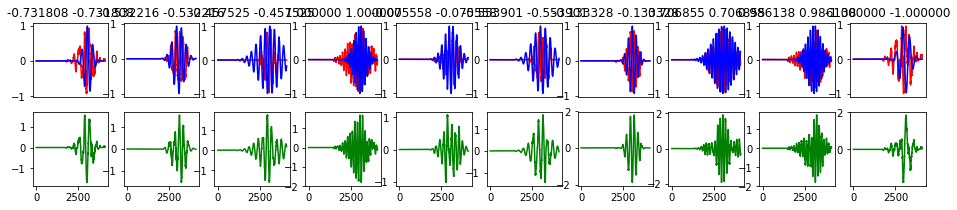

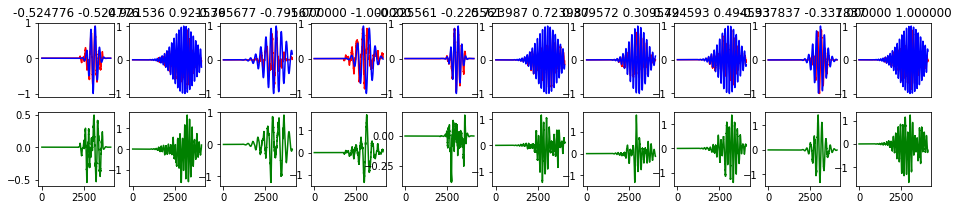

Iter:  100  Loss:   1152.939 re=   727.704 kl=   425.235  Time:  21.6s LR=0.005
Iter:  200  Loss:    696.743 re=   466.167 kl=   230.576  Time:  39.2s LR=0.005
Iter:  300  Loss:    427.123 re=   111.482 kl=   315.641  Time:  57.2s LR=0.005
Iter:  400  Loss:    356.890 re=   134.836 kl=   222.054  Time:  76.1s LR=0.005
Iter:  500  Loss:    341.820 re=   133.614 kl=   208.206  Time:  94.8s LR=0.005
Iter:  600  Loss:    209.068 re=    106.97 kl=   102.098  Time: 114.1s LR=0.005
Iter:  700  Loss:    341.375 re=   166.094 kl=   175.281  Time: 133.4s LR=0.005
Iter:  800  Loss:    134.082 re=   83.7105 kl=   50.3713  Time: 151.9s LR=0.005
Iter:  900  Loss:    341.369 re=   129.583 kl=   211.786  Time: 170.3s LR=0.005
Iter: 1000  Loss:    466.909 re=   102.979 kl=   363.929  Time: 189.3s LR=0.0005


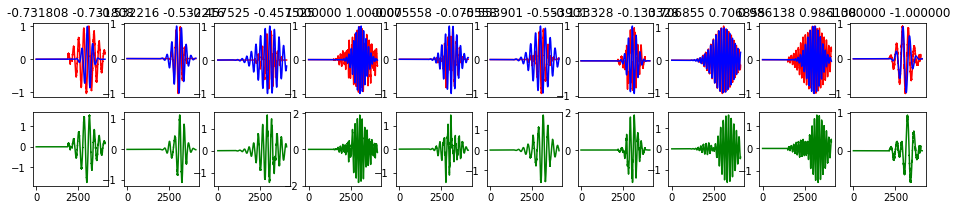

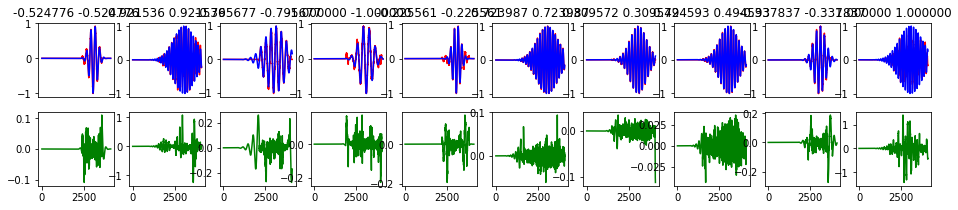

Iter: 1100  Loss:    120.402 re=   78.9156 kl=   41.4862  Time: 210.2s LR=0.0005
Iter: 1200  Loss:    108.242 re=   74.7275 kl=   33.5145  Time: 228.5s LR=0.0005
Iter: 1300  Loss:     97.715 re=   75.2333 kl=   22.4818  Time: 246.8s LR=0.0005
Iter: 1400  Loss:    107.206 re=   81.2502 kl=   25.9562  Time: 265.3s LR=0.0005
Iter: 1500  Loss:    155.639 re=   138.005 kl=   17.6335  Time: 283.2s LR=0.0005
Iter: 1600  Loss:     96.880 re=   71.6438 kl=    25.236  Time: 301.3s LR=0.0005
Iter: 1700  Loss:    112.039 re=   94.5387 kl=   17.5001  Time: 319.1s LR=0.0005
Iter: 1800  Loss:     91.789 re=     77.67 kl=   14.1187  Time: 338.7s LR=0.0005
Iter: 1900  Loss:    102.495 re=     88.93 kl=   13.5652  Time: 356.7s LR=0.0005
Iter: 2000  Loss:     78.634 re=   70.6057 kl=    8.0285  Time: 374.3s LR=0.0005


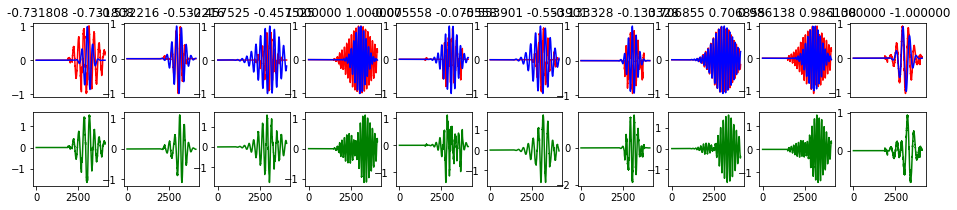

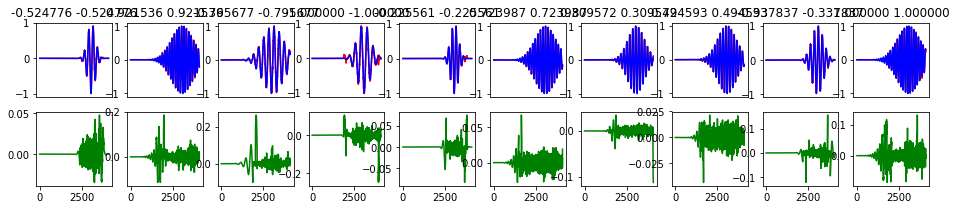

Iter: 2100  Loss:     84.659 re=   78.1966 kl=   6.46191  Time: 395.2s LR=0.0005
Iter: 2200  Loss:     77.429 re=    70.301 kl=   7.12785  Time: 413.0s LR=0.0005
Iter: 2300  Loss:     75.533 re=   71.6001 kl=   3.93282  Time: 430.6s LR=0.0005
Iter: 2400  Loss:     72.809 re=   70.7402 kl=   2.06881  Time: 448.4s LR=0.0005
Iter: 2500  Loss:     68.991 re=   66.0993 kl=   2.89171  Time: 466.0s LR=0.0005
Iter: 2600  Loss:     69.892 re=    68.437 kl=   1.45487  Time: 483.3s LR=0.0005
Iter: 2700  Loss:     70.369 re=   69.1578 kl=   1.21103  Time: 501.2s LR=0.0005
Iter: 2800  Loss:     68.935 re=    67.546 kl=   1.38879  Time: 518.2s LR=0.0005
Iter: 2900  Loss:     71.257 re=   69.9712 kl=   1.28619  Time: 536.0s LR=0.0005
Iter: 3000  Loss:     66.475 re=   64.8702 kl=   1.60465  Time: 554.0s LR=5e-05


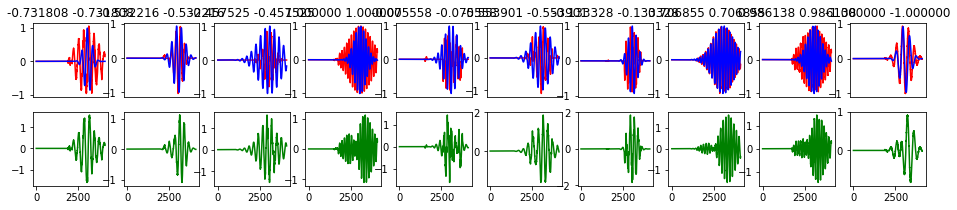

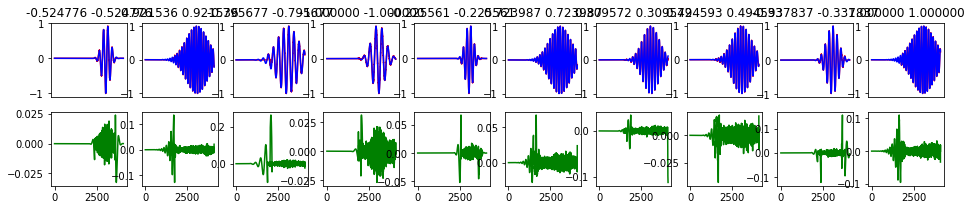

Iter: 3100  Loss:     65.587 re=   64.1857 kl=    1.4015  Time: 574.1s LR=5e-05
Iter: 3200  Loss:     66.018 re=    64.752 kl=   1.26554  Time: 591.2s LR=5e-05
Iter: 3300  Loss:     65.149 re=   63.8823 kl=   1.26633  Time: 609.2s LR=5e-05
Iter: 3400  Loss:     66.000 re=     64.93 kl=   1.07003  Time: 628.4s LR=5e-05
Iter: 3500  Loss:     65.787 re=    64.558 kl=   1.22866  Time: 647.9s LR=5e-05
Iter: 3600  Loss:     64.846 re=    63.907 kl=  0.939514  Time: 667.2s LR=5e-05
Iter: 3700  Loss:     69.056 re=    67.659 kl=   1.39681  Time: 685.7s LR=5e-05
Iter: 3800  Loss:     67.362 re=   66.1499 kl=   1.21192  Time: 703.9s LR=5e-05
Iter: 3900  Loss:     66.021 re=   64.7276 kl=    1.2936  Time: 722.1s LR=5e-05
Iter: 4000  Loss:     65.321 re=   64.0912 kl=   1.23007  Time: 740.2s LR=5e-05


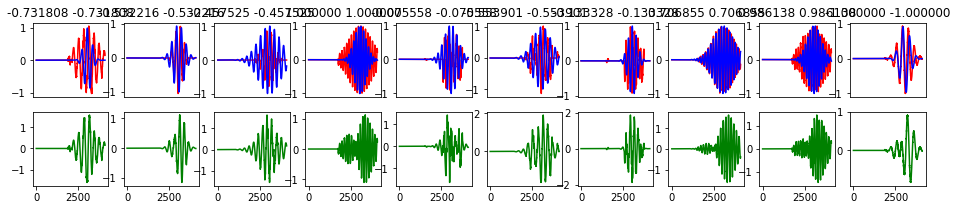

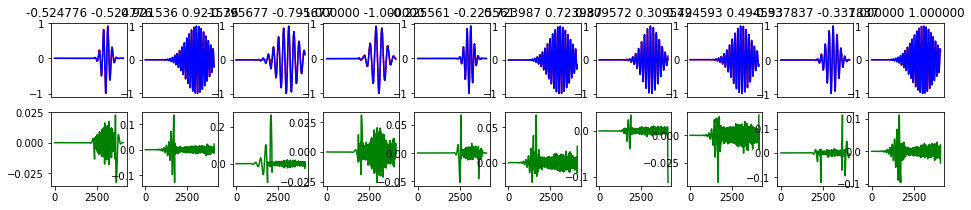

Iter: 4100  Loss:     67.021 re=   65.7116 kl=   1.30934  Time: 761.2s LR=5e-05
Iter: 4200  Loss:     64.852 re=   63.6269 kl=   1.22544  Time: 779.4s LR=5e-05
Iter: 4300  Loss:     76.212 re=   75.0862 kl=   1.12587  Time: 797.7s LR=5e-05
Iter: 4400  Loss:     64.880 re=   63.6471 kl=   1.23297  Time: 815.6s LR=5e-05
Iter: 4500  Loss:     64.906 re=   63.5888 kl=   1.31677  Time: 833.9s LR=5e-05
Iter: 4600  Loss:     66.029 re=   64.4595 kl=   1.56932  Time: 852.3s LR=5e-05
Iter: 4700  Loss:     64.634 re=   63.4522 kl=   1.18229  Time: 870.8s LR=5e-05
Iter: 4800  Loss:     67.604 re=   66.3979 kl=   1.20586  Time: 888.6s LR=5e-05
Iter: 4900  Loss:     65.053 re=   63.7821 kl=   1.27048  Time: 906.7s LR=5e-05
Iter: 5000  Loss:     67.658 re=   66.3362 kl=   1.32156  Time: 923.6s LR=1e-05


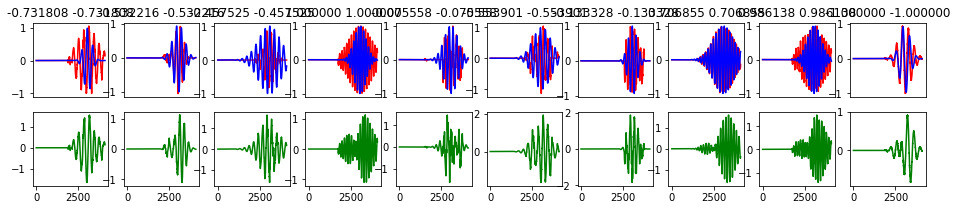

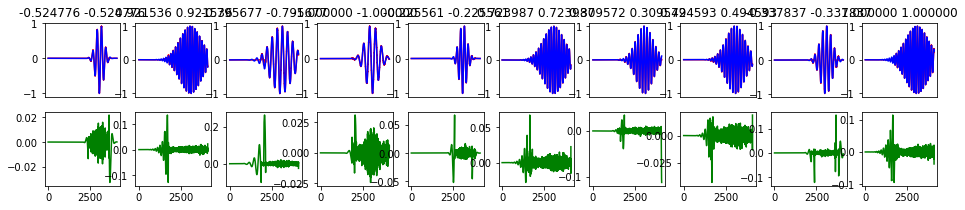

Iter: 5100  Loss:     69.799 re=   68.6393 kl=   1.15984  Time: 942.4s LR=1e-05
Iter: 5200  Loss:     68.281 re=   67.0221 kl=   1.25923  Time: 960.2s LR=1e-05
Iter: 5300  Loss:     66.611 re=   65.4505 kl=   1.16002  Time: 977.4s LR=1e-05
Iter: 5400  Loss:     66.876 re=   65.6151 kl=   1.26133  Time: 994.5s LR=1e-05
Iter: 5500  Loss:     65.025 re=   63.7234 kl=   1.30124  Time: 1011.7s LR=1e-05
Iter: 5600  Loss:     65.809 re=   64.6565 kl=   1.15289  Time: 1028.7s LR=1e-05
Iter: 5700  Loss:     64.584 re=   63.4045 kl=   1.17991  Time: 1045.7s LR=1e-05
Iter: 5800  Loss:     64.457 re=   63.2845 kl=   1.17272  Time: 1063.2s LR=1e-05
Iter: 5900  Loss:     64.628 re=   63.3729 kl=   1.25484  Time: 1080.8s LR=1e-05
Model saved in path: /tmp/lin/vae.ckpt


In [70]:
###############
###############   Training
###############
start_time = time.time()

summary_writer = tf.summary.FileWriter("/tmp/lin/.tensorboard/%04d"%COUNTER)
COUNTER = COUNTER+1

LR = [0.005]*1000 + [0.0005]*2000 + [0.00005]*2000 + [0.00001]*1000 

#saver.restore(sess, "/tmp/lin/vae.ckpt")
#print("Model restored.")

for epoch in range(len(LR)):
    lra = LR[epoch]
    
    summ = loss = re = kl = 0
    index = [i for i in range(N)]   
    #random.shuffle(index)
    
    while len(index)>0:
        index_size = len(index)
        if index_size < batch_size: break;  ### Don't process incomplete batch just because conv1d_transpose require static input dimension
        batch_index = [index.pop() for _ in range(min(batch_size,index_size))]
        
        _, loss, re, kl = sess.run([solver, vae_loss, recon_loss, kl_loss], feed_dict={X: Xt[batch_index,:], c: Yt[batch_index,:], lr:lra })
        #_,_,_,_, summ = sess.run([solver, mean_loss_op, mean_kl_loss_op, mean_recon_loss_op, merged], feed_dict={X: Xt[batch_index,:], c: Yt[batch_index,:], lr:LR})
        #print (loss, re, kl)

    if TBOARD: summary_writer.add_summary(summ, epoch)
    
    if math.isnan(loss):
        print('Iter: %4d  Loss: %10.3f re=%10g kl=%10g  Time: %5.1fs LR=%g' % (epoch, loss, re, kl, time.time()-start_time, lra ))
        assert False, "Nan detecteced !"
    if epoch % 100 == 0:
        print('Iter: %4d  Loss: %10.3f re=%10g kl=%10g  Time: %5.1fs LR=%g' % (epoch, loss, re, kl, time.time()-start_time, lra ))
    if epoch % 1000 == 0:
        
        PO = 0
        SID = 3*NTYPE   #starting ID
        zz = 0*np.random.randn(NTYPE, z_dim)
        samples = sess.run(X_ntype, feed_dict={z: zz, c: np.reshape(Yv[SID:SID+NTYPE],  (NTYPE, 2) ) } )

        fig = plt.figure(figsize=(16, 3))
        gs = gridspec.GridSpec(2, NTYPE)
        ##gs.update(wspace=0.2, hspace=0.15)
        for i, sample in enumerate(samples):
            
            #plt.axis('off')
            ax = plt.subplot(gs[i])
            plt.xticks([], [])
            plt.title("%4f %4f" % (Yv[SID+i,0], Yv[SID+i,1]) )
            plt.plot(sample[PO], 'r')
            plt.plot(Xv[SID+i,PO,:], 'b')

            ax = plt.subplot(gs[i+NTYPE])
            plt.plot(sample[0]-Xv[SID+i,PO,:], 'g')
        plt.show()

    if epoch % 100099999 == 0:
        
        PO = 0
        SID = 3*NTYPE   #starting ID
        zz = 0*np.random.randn(NTYPE, z_dim)
        samples = sess.run(X_ntype, feed_dict={z: zz, c: np.reshape(Yt[SID:SID+NTYPE],  (NTYPE, 2) ) } )

        fig = plt.figure(figsize=(16, 3))
        gs = gridspec.GridSpec(2, NTYPE)
        ##gs.update(wspace=0.2, hspace=0.15)
        for i, sample in enumerate(samples):
            
            #plt.axis('off')
            ax = plt.subplot(gs[i])
            plt.xticks([], [])
            plt.title("%4f %4f" % (Yt[SID+i,0], Yt[SID+i,1]) )
            plt.plot(sample[PO], 'r')
            plt.plot(Xt[SID+i,PO,:], 'b')

            ax = plt.subplot(gs[i+NTYPE])
            plt.plot(sample[0]-Xt[SID+i,PO,:], 'g')
        plt.show()
        
save_path = saver.save(sess, "/tmp/lin/vae.ckpt")
print("Model saved in path: %s" % save_path)        

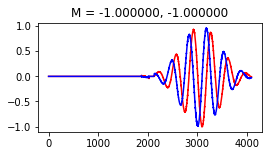

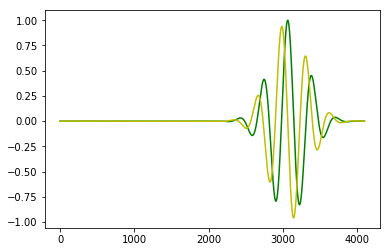

In [89]:

###
###  Test if it can produce an input GW signal
### 
ID = 30

zz = 0*np.random.randn(1, z_dim)
samples = sess.run(X_one, feed_dict={z: zz, c: np.reshape(Ys[ID],  (1, 2) ) } )[0]

plt.figure(figsize=(4, 2))
#plt.figure()
plt.title("M = %f, %f" % (Ys[ID,0],Ys[ID,1]) )
plt.plot(samples[0], 'r')
plt.plot(samples[1], 'b')
#plt.plot(Xs[ID,:], 'b')
plt.show()
plt.plot(samples[0]-Xs[ID,0,:], 'g')
plt.plot(samples[1]-Xs[ID,1,:], 'y')
plt.show()


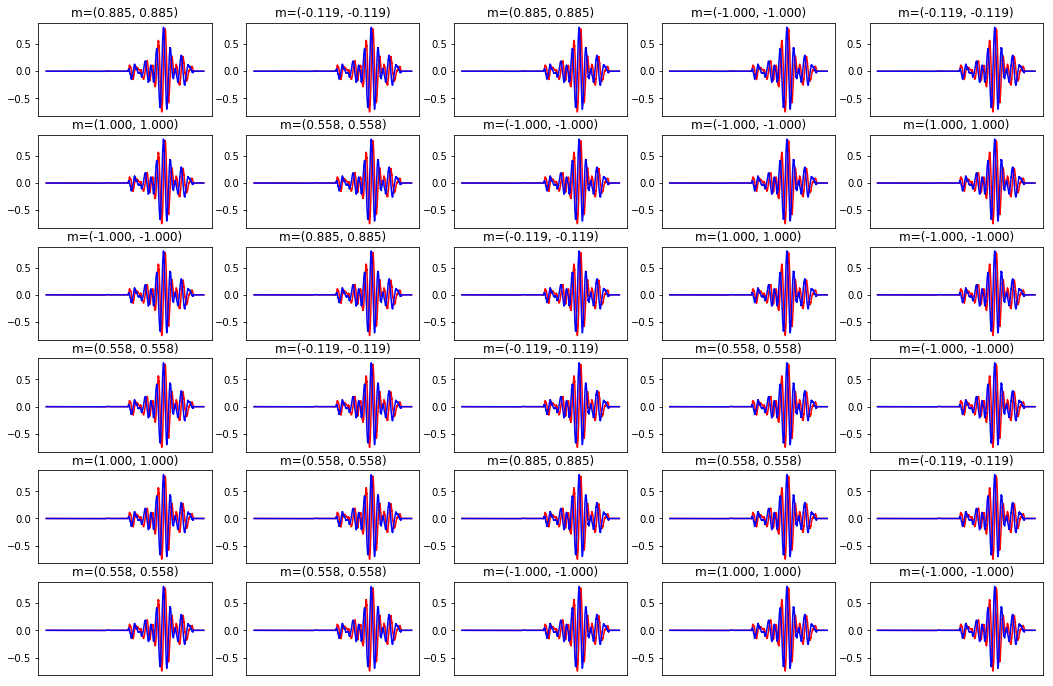

In [64]:
###
###  Test if it can produce many input GW signals
###
import random
N=30
X_testN = P(z, c, N)    ###  generation
test_X = Xs
test_Y = Ys


plt.figure(figsize=(18,12))

ranidx = random.sample(range(len(test_X)), N)   ## test randomly sample
zz = np.random.randn(N, z_dim)
w1 = sess.run(X_testN, feed_dict={z: zz, c: np.reshape(test_Y[ranidx],  (N, 2) ) } )

for i in range(len(ranidx)):
    plt.subplot(6,5,i+1)         
    plt.title("m=(%.3f, %.3f)"%(test_Y[ranidx[i],0],test_Y[ranidx[i],1]))
    
    plt.plot(w1[i,0,:], 'r')
    plt.plot(w1[i,1,:], 'b')
    #plt.plot(test_X[ranidx[i],0,:]-w1[i,0,:], 'g')
    #plt.plot(test_X[ranidx[i],1,:]-w1[i,1,:], 'g')
    plt.xticks([])
   
    if (i > N): break
plt.show()
    
    
#plt.savefig("VAE_testdiff.png")

            
            
    

In [ ]:
###
###  Draw sample over "2D" latent space
###
import random
plt.figure(figsize=(18,17))

NX=11
NUM=NX*NX
####ranidx = random.sample(range(len(Xt)), NUM)   ## test randomly sample

X_testN = P(z, c, NUM)    ###  generation

zz = np.zeros([NUM, z_dim])
zz_x = np.linspace(-20,20,NX)
for ix in range(NX):
 for iy in range(NX):
   zz[ix*NX+iy, 0]=zz_x[ix]
   zz[ix*NX+iy, 1]=zz_x[iy]
   #zz[ix*NX+iy, 3]=zz_x[ix]
   #zz[ix*NX+iy, 4]=zz_x[iy]

#y = np.array( [0, np.pi/5.,  np.pi/2.5,  np.pi/1.2, np.pi ]*150 )
ID=3
w1 = sess.run(X_testN, feed_dict={z: zz, c: np.tile( Ys[ID], (NUM,1) ) } )

for i in range(NUM):
    plt.subplot(NX,NX,i+1)
    #plt.title("m=(%.1f, %.1f)"%(Yt[ranidx[i],0],Yt[ranidx[i],1]))
    
    if (i==NUM/2): plt.plot(w1[i,0], 'g')
    else:          plt.plot(w1[i,0], 'r')

    plt.plot(Xs[ID,0,:], 'b')
    #plt.plot(Xt[ID+1,:], 'b')
    plt.xticks([])
    plt.yticks([])
   
    if (i > NUM): break
plt.show()
#plt.savefig("VAE_testdiff.png")     
            
    

In [176]:
np.tile( Ys[2] , (4,1) )


array([[-0.7179469, -0.7179469],
       [-0.7179469, -0.7179469],
       [-0.7179469, -0.7179469],
       [-0.7179469, -0.7179469]], dtype=float32)